In [ ]:
#Pandas, Numpy
import numpy as np
import pandas as pd

#Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Read file from URL
import requests

#sklearn models, Pipeline & Metrics
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, ConfusionMatrixDisplay
#from sklearn.metrics import plot_confusion_matrix

# Tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
#Supress Tensorflow Info Warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'


In [2]:
"""Read the Dataset available from https://ibm.box.com/v/tabformer-data as a tar compressed file
Due to the limitation of the github and git lfs in persisting large file. A sample file of size 50,000 records are saved to
file transactions_sample.csv for this analysis."""

df = pd.read_csv('Data/transactions_sample.csv')

In [3]:
# Data Analysis
df.isnull().sum()

Unnamed: 0.1          0
Unnamed: 0            0
User                  0
Card                  0
Year                  0
Month                 0
Day                   0
Time                  0
Amount                0
Use Chip              0
Merchant Name         0
Merchant City         0
Merchant State     5664
Zip                6002
MCC                   0
Errors?           49192
Is Fraud?             0
dtype: int64

In [4]:
#Data Cleanup

#Fill missing values in the columns
#For all Online transactions, Merchant State and Zip is Nan. 
df['Merchant State'] = df['Merchant State'].fillna('ZZ')
df['Zip'] = df['Zip'].fillna(0)

#Since the error, column is irrelevant for this use-case, we can drop the column
df.drop(columns='Errors?', inplace=True)

#Remove the $ symbol from the amount and change the datatype to numeric 
#Also make it logarthimic, addressing refunds (negatives)
df['Amount'] = df['Amount'].apply(lambda x: x[1:]).astype(float).apply(lambda amt: max(1, amt)).apply(np.log)

#Rename the column 'Is Fraud?' to Fraud and also change it to int
df.rename(columns={'Is Fraud?': 'Fraud'}, inplace=True)
df['Fraud'] = df['Fraud'].apply(lambda x: 1 if x == 'Yes' else 0)

#Convert Year, Month, Date, Time to Pandas Datetime and Drop Columns - Year, Month, Day, Time
hour_min = df['Time'].str.split(':', expand=True)
df['Date'] = pd.to_datetime(dict(year=df['Year'], month=df['Month'], day=df['Day'], hour=hour_min[0], minute=hour_min[1])).astype(int)
df.drop(columns= {'Year', 'Month', 'Day', 'Time'}, inplace=True)

#Card 
print (df['Card'].value_counts())

"""Based on the value of the Card feature, this does not provide any value. In the real-time scenarios card numbers are typically 
encrypted values and they can be used. For this dataset, we will drop the 'Card' column."""

#Since the card,  column is irrelevant for this use-case, we can drop the column
df.drop(columns='Card', inplace=True)


0    17783
1    13282
2     8898
3     5754
4     2627
5     1191
6      363
7       94
8        8
Name: Card, dtype: int64


In [5]:
df.isna().sum()

Unnamed: 0.1      0
Unnamed: 0        0
User              0
Amount            0
Use Chip          0
Merchant Name     0
Merchant City     0
Merchant State    0
Zip               0
MCC               0
Fraud             0
Date              0
dtype: int64

In [6]:
"""For this project we will consider only States within the United States. For international transactions, we will 
decline those transactions before it reaches our ML model for decisioning"""

# Remove rows of data where the card transaction are coming from International countries.

# drop all rows that contains Countries listed in Merchant State
df.drop(df[df['Merchant State'].str.len() >2].index, inplace=True)

print (df['Merchant State'].value_counts().head(5))

ZZ    5664
CA    5333
TX    3699
FL    3010
NY    2837
Name: Merchant State, dtype: int64


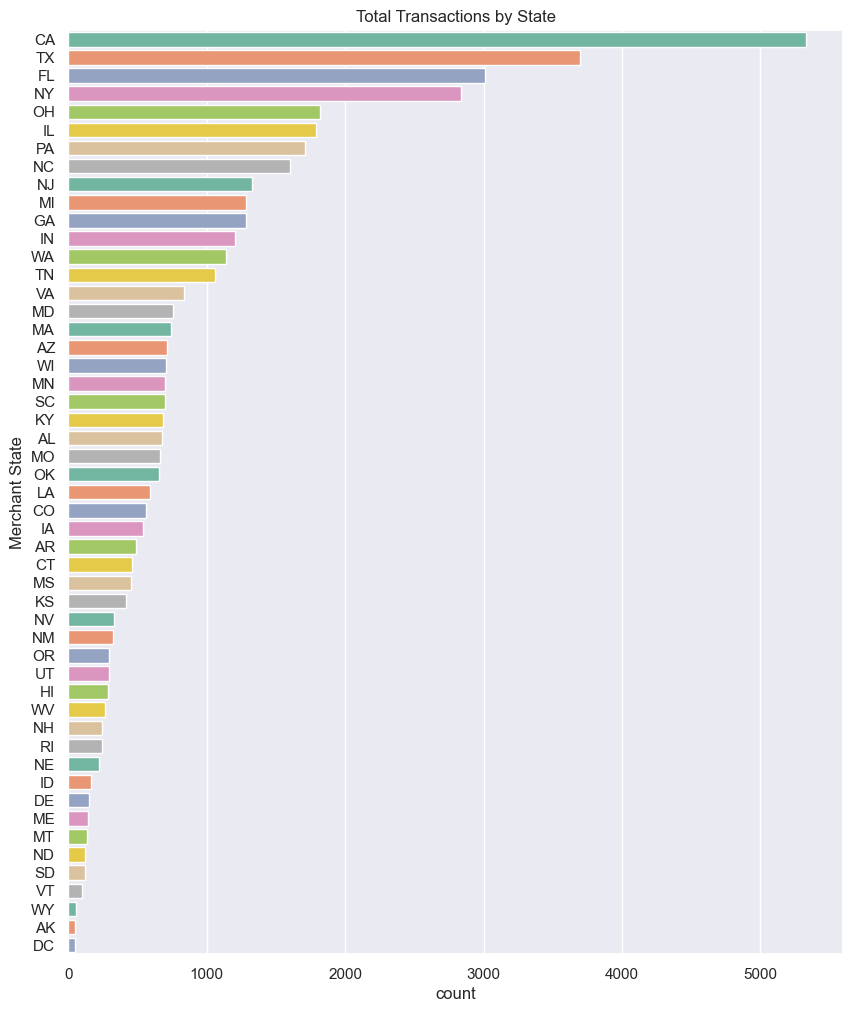

In [7]:
# Display Total transactions by state

#Drop online transactions alone for visualization by States
df_disp = df.drop(df[df['Merchant State'].str.endswith('ZZ')].index)

plt.figure(figsize=(10, 12))
sns.set_theme(style="darkgrid")
sns.countplot(df_disp, y='Merchant State', order=df_disp['Merchant State'].value_counts().index, orient='h', palette="Set2")
plt.title('Total Transactions by State')
plt.savefig("Images/TotalTransactions.png")
plt.show()

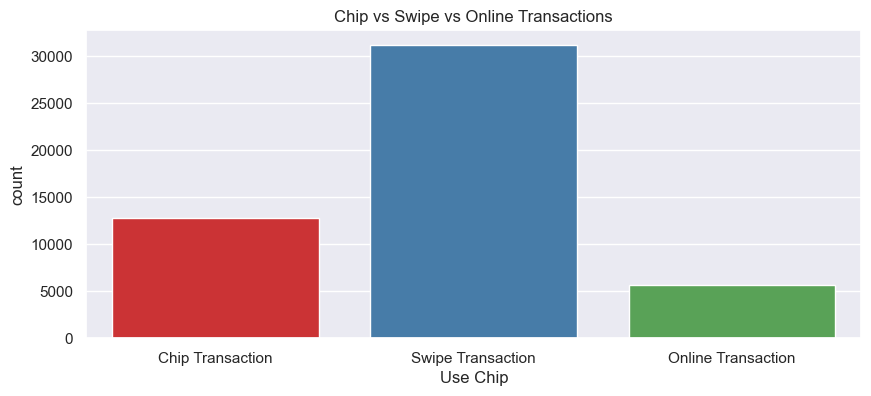

In [8]:
#Visualize Chip/Swipe/Online Transactions 

sns.set_theme(style="darkgrid")
plt.figure(figsize=(10, 4))
x = sns.countplot(x="Use Chip", data=df, palette="Set1")
plt.title('Chip vs Swipe vs Online Transactions')
plt.savefig("Images/ChipSwipeOnlineTransactions.png")
plt.show()

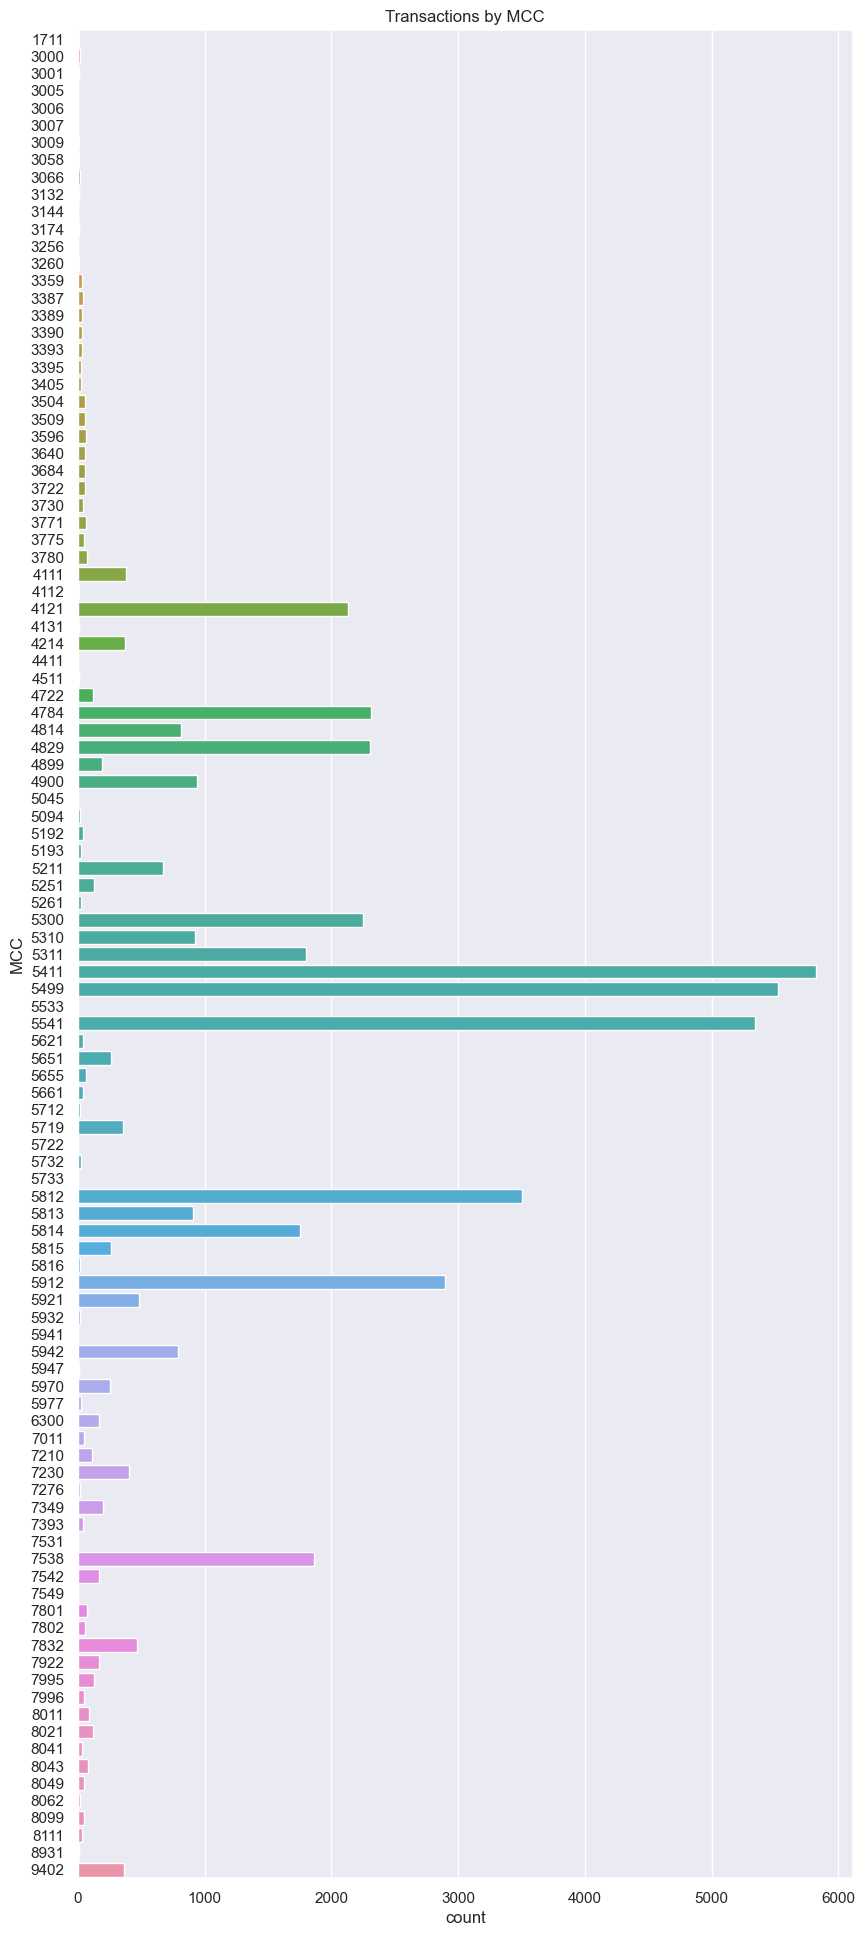

In [9]:
#Visualize MCC Transactions 

sns.set_theme(style="darkgrid")
plt.figure(figsize=(10, 24))
x = sns.countplot(y="MCC", data=df)
plt.title('Transactions by MCC')
plt.savefig("Images/TransactionsByMCC.png") 

In [10]:
X = df.drop(columns=['Fraud','Merchant City', 'Merchant State' ])
y = df['Fraud']

In [11]:
X.head(5), y.head(5)

(   Unnamed: 0.1  Unnamed: 0  User    Amount           Use Chip  \
 0        104241    11578033   962  4.736198   Chip Transaction   
 1        199676     3079286   258  3.471345   Chip Transaction   
 2        140199    15853979  1287  5.157848   Chip Transaction   
 3        132814    21215815  1730  2.894253   Chip Transaction   
 4        408697     1295691   102  4.254193  Swipe Transaction   
 
          Merchant Name      Zip   MCC                 Date  
 0 -7759074308363763111  11735.0  5651  1496154720000000000  
 1 -2532682281992688918   3451.0  4121  1492008480000000000  
 2  3042903254138627396  38016.0  8011  1544047740000000000  
 3  -183925611412832543  95035.0  5813  1457520420000000000  
 4 -6334940336115803711  60153.0  7538  1380618300000000000  ,
 0    0
 1    0
 2    0
 3    0
 4    0
 Name: Fraud, dtype: int64)

In [12]:
transformer_columns = ['Use Chip']
transformer = make_column_transformer((OneHotEncoder(drop='if_binary', handle_unknown='ignore'), transformer_columns), remainder=StandardScaler())

In [13]:
# Split the data into train and test set.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_scaled = transformer.fit_transform(X)
X_test_scaled = transformer.fit(X_test)

In [14]:
#Logistic Regression explored for Credit Card Fraud Detection

pipe = Pipeline([('transformer', transformer),
                 ('lgr', LogisticRegression())])
lgr_param_grid = {   
    'lgr__penalty' : ['l2'],
    'lgr__C' : np.logspace(-4, 4, 20),
    'lgr__max_iter' : [100, 1000,2500, 5000]
}
lgr_grid = GridSearchCV(pipe, param_grid=lgr_param_grid, scoring='roc_auc', error_score='raise')
lgr_grid.fit(X_train, y_train)

GridSearchCV(error_score='raise',
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       handle_unknown='ignore'),
                                                                         ['Use '
                                                                          'Chip'])])),
                                       ('lgr', LogisticRegression())]),
             param_grid={'lgr__C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'lgr__max_iter': [100, 1000, 2500, 5000],
                         'lgr__penalty': ['l2']},
             scoring='roc_auc')

In [15]:
print(lgr_grid.best_params_)
print(lgr_grid.best_estimator_)
print(lgr_grid.best_score_)

{'lgr__C': 11.288378916846883, 'lgr__max_iter': 100, 'lgr__penalty': 'l2'}
Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['Use Chip'])])),
                ('lgr', LogisticRegression(C=11.288378916846883))])
0.8653371030865038


In [16]:
#Support Vector Machines explored for Credit Card Fraud Detection

pipe2 = Pipeline([('transformer', transformer),
                 ('svm', SVC())])
# svm_param_grid = {
#     'svm__kernel' : ['linear', 'rbf', 'poly'],
#     'svm__gamma' : [0.1, 1, 10],
#     'svm__C' : [0.1, 1, 10],
#     'svm__degree' :[0, 1, 2, 3, 4, 5, 6]
# }

svm_param_grid = {
    'svm__kernel' : ['linear'],
    'svm__gamma' : [0.1, 1, 10],
    'svm__C' : [0.1, 1, 10],
    'svm__degree' :[0, 1, 2, 3]
}

svm_grid = GridSearchCV(pipe2, param_grid=svm_param_grid, scoring='roc_auc', error_score='raise')
svm_grid.fit(X_train, y_train)


GridSearchCV(error_score='raise',
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       handle_unknown='ignore'),
                                                                         ['Use '
                                                                          'Chip'])])),
                                       ('svm', SVC())]),
             param_grid={'svm__C': [0.1, 1, 10], 'svm__degree': [0, 1, 2, 3],
                         'svm__gamma': [0.1, 1, 10],
                         'svm__kernel': ['linear']},
             scoring='roc_auc')

In [17]:
print(svm_grid.best_params_)
print(svm_grid.best_estimator_)
print(svm_grid.best_score_)

{'svm__C': 1, 'svm__degree': 0, 'svm__gamma': 0.1, 'svm__kernel': 'linear'}
Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['Use Chip'])])),
                ('svm', SVC(C=1, degree=0, gamma=0.1, kernel='linear'))])
0.7374301747071923


In [ ]:
#Random Forest Classifier explored for Credit Card Fraud Detection

pipe3 = Pipeline([('transformer', transformer),
                 ('rfc', RandomForestClassifier())])
rfc_param_grid = {
    'rfc__n_estimators' : [100, 200],
    'rfc__criterion' : ['gini', 'entropy'],
    'rfc__max_features' : ['sqrt'],
     'rfc__max_depth' :[int(x) for x in np.linspace(10, 110, num = 11)],
    'rfc__min_samples_split' : [2, 5],
    'rfc__min_samples_leaf' : [1, 2]
}
    
rfc_grid = GridSearchCV(pipe3, param_grid=rfc_param_grid, scoring='roc_auc', error_score='raise')
rfc_grid.fit(X_train, y_train)




In [ ]:
print(rfc_grid.best_params_)
print(rfc_grid.best_estimator_)
print(rfc_grid.best_score_)

In [ ]:
#ANN explored for Credit Card Fraud Detection

model = Sequential([
    Dense(50, activation = 'relu'),
    Dense(100, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
    ])

# Optimizer(Adam), Loss (Binary_CrossEntropy) and Metrics (ROC Curve)
model.compile(optimizer="adam", loss = 'bce', metrics = ['AUC'])

X_t = transformer.fit_transform(X)

history = model.fit(X_t, y, validation_split = 0.2, epochs = 50, batch_size=10, verbose = 0)
pred = model.predict(X_t)

keras.metrics.confusion_matrix(y_test, pred)

In [ ]:
#Plot model accuracy of ANN

plt.plot(history.history['AUC'])
plt.plot(history.history['val_AUC'])
plt.title('ANN model AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.savefig("ANNmodelAUC.png")
plt.show()

print(history.history['AUC'][-1])
print(history.history['val_AUC'][-1])